##Set-up

In [ ]:
!pip install gurobipy
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.0f}'.format

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 32.1 MB/s eta 0:00:00


In [ ]:
data = pd.read_excel('RegencyClientList.xlsx')
df = data.copy()

risk_ratings = df['Risk Rating']
complexity_levels = df['Complexity Level']
annual_spend = df['Annual Spend Volume']
num_cards = df['# of Cards']
clients = len(df)

##Simulation (Q2)

*Given constants*

In [ ]:
#migration costs
migration_fc = 500000
migration_costs = {
    1: 2000,
    2: 5000,
    3: 7000,
    }
def get_migration_cost(complexity_level):
    if complexity_level == 1:
        return 2000
    elif complexity_level == 2:
        return 5000
    elif complexity_level == 3:
        return 7000
    else:
        return 0

#ongoing annual costs
ongoing_fc = 200000
ongoing_costs = {
    1: 1500,
    2: 2000,
    3: 3000,
    }
def get_ongoing_cost(complexity_level):
    if complexity_level == 1:
        return 1500
    elif complexity_level == 2:
        return 2000
    elif complexity_level == 3:
        return 3000
    else:
        return 0

#card associated costs
card_cost_to_issue = 45
card_annual_service_cost = 40

#other annual rates
attrition_rate = 0.1
annual_growth = 0.08
annual_card_growth = 0.1
annual_growth_std_dev = 0.01

#revenue related constants
flat_charge = 5000 #per client, not per card
variable_charge = 0.01 #1% of total annual spend

#risk-related constants
risk_data = {
    7: {'default_probability': 0.1, 'default_months': 6},
    6: {'default_probability': 0.05, 'default_months': 4},
    5: {'default_probability': 0.03, 'default_months': 3},
    4: {'default_probability': 0.02, 'default_months': 3},
    3: {'default_probability': 0.01, 'default_months': 3},
    2: {'default_probability': 0.005, 'default_months': 3},
    1: {'default_probability': 0.001, 'default_months': 3}
}

*Simulation function (documented ver.) - if needed to debug*

In [ ]:
def documented_simulation(data, year):
  df = data.copy()

  #migration costs
  if (year == 1):
    migration_cost = migration_fc + df['Complexity Level'].apply(get_migration_cost).sum()
  else:
    migration_cost = 0
  print("Migration Cost:", migration_cost)

  #annual ongoing costs
  ongoing_cost = ongoing_fc + df['Complexity Level'].apply(get_ongoing_cost).sum()
  print("Ongoing Cost:", ongoing_cost)

  #update card number growth
  curr_num_cards = df['# of Cards']
  new_cards = curr_num_cards * np.random.normal(loc = .1, scale = .01)
  print("Current cards:", curr_num_cards.sum())
  print("New cards issued:", new_cards.sum())

  #update spending growth
  curr_annual_spend = df['Annual Spend Volume']
  new_spend = curr_annual_spend * np.random.normal(loc = .08, scale = .01)
  print("Current spend:", curr_annual_spend.sum())
  print("Spending growth:", new_spend.sum())

  #update card number and spending in df
  df['# of Cards'] = curr_num_cards + new_cards
  df['Annual Spend Volume'] = curr_annual_spend + new_spend
  spend = df['Annual Spend Volume'].sum()

  #card related costs
  card_issue_cost = new_cards.sum() * card_cost_to_issue
  print("Card Issue Cost: ", card_issue_cost)
  card_service_cost = (curr_num_cards + new_cards).sum() * card_annual_service_cost
  print("Card Service Cost: ", card_service_cost)

  #calculate default costs based on risk rating
  df['Default Occurrence'] = df['Risk Rating'].map(lambda x: np.random.binomial(1, risk_data[x]['default_probability']))
  print("Number of Defaults:", df['Default Occurrence'].sum())

  #calculate default costs
  default_costs = np.where(df['Default Occurrence'] == 1, (df['Annual Spend Volume'] / 12) * df.apply(lambda row: risk_data[row['Risk Rating']]['default_months'], axis=1), 0)

  total_default_costs = default_costs.sum()
  print("Default Costs:", default_costs.sum())

  #calculate total cost
  total_cost = migration_cost + ongoing_cost + card_service_cost + card_issue_cost + total_default_costs
  print("Total Cost:", total_cost)

  #calculate total revenue
  revenue = len(data) * flat_charge + spend.sum() * variable_charge
  total_revenue = revenue.sum()
  print("Total Revenue:", total_revenue)

  #calculate total profit
  total_profit = total_revenue - total_cost
  print("Total Profit:", total_revenue - total_cost)

  #attrition update
  df["Attrition"] = np.random.binomial(1, attrition_rate, len(df))
  new_df = df[df['Attrition'] == 0]
  print("Lost Clients:", df["Attrition"].sum())
  print("Remaining Clients:", len(new_df))

  return total_cost, total_revenue, total_profit, new_df

*Simulation function (clean ver.)*

In [ ]:
def simulation(data, year):
  df = data.copy()

  #migration costs
  if (year == 1):
    migration_cost = migration_fc + df['Complexity Level'].apply(get_migration_cost).sum()
  else:
    migration_cost = 0

  #annual ongoing costs
  ongoing_cost = ongoing_fc + df['Complexity Level'].apply(get_ongoing_cost).sum()

  #update card number growth
  curr_num_cards = data['# of Cards']
  new_cards = curr_num_cards * np.random.normal(loc = .1, scale = .01)

  #update spending growth
  curr_annual_spend = data['Annual Spend Volume']
  new_spend = curr_annual_spend * np.random.normal(loc = .08, scale = .01)

  #update card number and spending in df
  df.loc[:,'# of Cards'] = curr_num_cards + new_cards
  df.loc[:, 'Annual Spend Volume'] = curr_annual_spend + new_spend
  spend = df['Annual Spend Volume'].sum()

  #card related costs
  card_issue_cost = new_cards.sum() * card_cost_to_issue
  card_service_cost = (curr_num_cards + new_cards).sum() * card_annual_service_cost

  #calculate default costs based on risk rating
  df['Default Occurrence'] = df['Risk Rating'].map(lambda x: np.random.binomial(1, risk_data[x]['default_probability']))

  #calculate default costs
  default_costs = np.where(df['Default Occurrence'] == 1, (df['Annual Spend Volume'] / 12) * df.apply(lambda row: risk_data[row['Risk Rating']]['default_months'], axis=1), 0)

  total_default_costs = default_costs.sum()

  #calculate total cost
  total_cost = migration_cost + ongoing_cost + card_service_cost + card_issue_cost + total_default_costs

  #calculate total revenue
  revenue = len(data) * flat_charge + spend.sum() * variable_charge
  total_revenue = revenue.sum()

  #calculate total profit
  total_profit = total_revenue - total_cost

  #attrition update
  df["Attrition"] = np.random.binomial(1, attrition_rate, len(df))
  new_df = df[df['Attrition'] == 0]

  return total_cost, total_revenue, total_profit, new_df

*Three year simulation function*

In [ ]:
def three_year_sim():
  data = pd.read_excel('RegencyClientList.xlsx')
  df = data.copy()

  #year 1
  year1_total_cost, year1_total_revenue, year1_total_profit, df = simulation(df, 1)

  #year 2
  year2_total_cost, year2_total_revenue, year2_total_profit, df = simulation(df, 2)

  #year 3
  year3_total_cost, year3_total_revenue, year3_total_profit, df = simulation(df, 3)

  #sum three years
  three_year_cost = year1_total_cost + year2_total_cost + year3_total_cost
  three_year_revenue = year1_total_revenue + year2_total_revenue + year3_total_revenue
  three_year_profit = year1_total_profit + year2_total_profit + year3_total_profit

  return year1_total_cost, year2_total_cost, year3_total_cost, three_year_cost, \
         year1_total_revenue, year2_total_revenue, year3_total_revenue, \
         three_year_revenue, year1_total_profit, year2_total_profit, \
         year3_total_profit, three_year_profit

*Distributions (100 simulations)*

Year 1 Mean Cost: 8910471.48
Cost Standard Deviation: 6059166.67
Year 1 Mean Profit: 9910959.77
Revenue Standard Deviation: 80113.10
Year 1 Mean Profit: 1000488.30
Profit Standard Deviation: 6057960.10


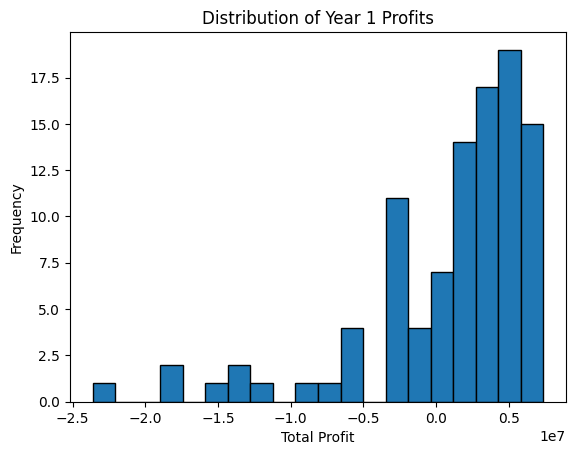

Year 2 Mean Cost: 6353762.46
Cost Standard Deviation: 4447991.51
Year 2 Mean Profit: 9595199.22
Revenue Standard Deviation: 498359.02
Year 2 Mean Profit: 3241436.76
Profit Standard Deviation: 4489257.22


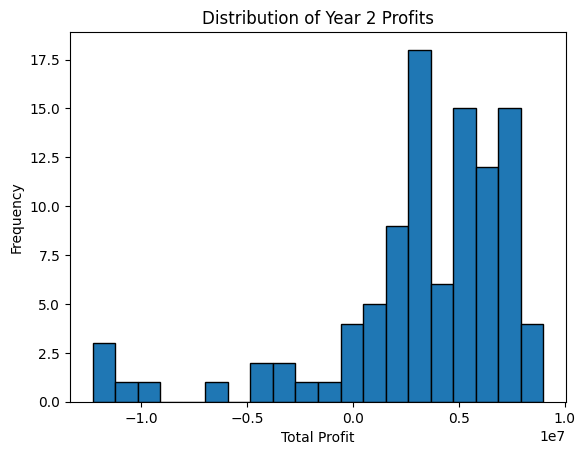

Year 3 Mean Cost: 5759057.86
Cost Standard Deviation: 4456469.60
Year 3 Mean Profit: 9241857.08
Revenue Standard Deviation: 741553.18
Year 3 Mean Profit: 3482799.22
Profit Standard Deviation: 4436346.32


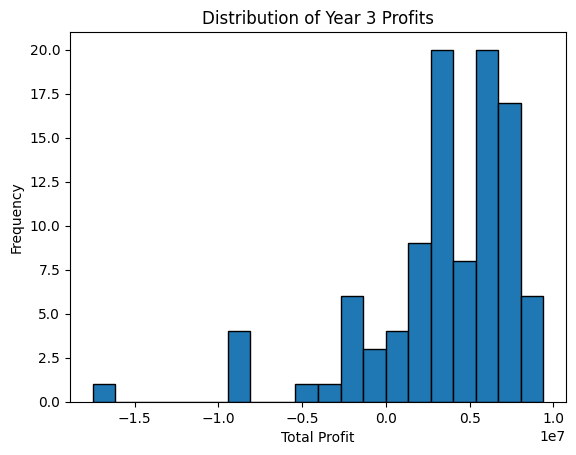

Three Year Mean Cost: 21023291.79
Cost Standard Deviation: 9761777.15
Three Year Mean Revenue: 28748016.07
Revenue Standard Deviation: 1168060.27
Three Year Mean Profit: 7724724.28
Profit Standard Deviation: 9765319.27


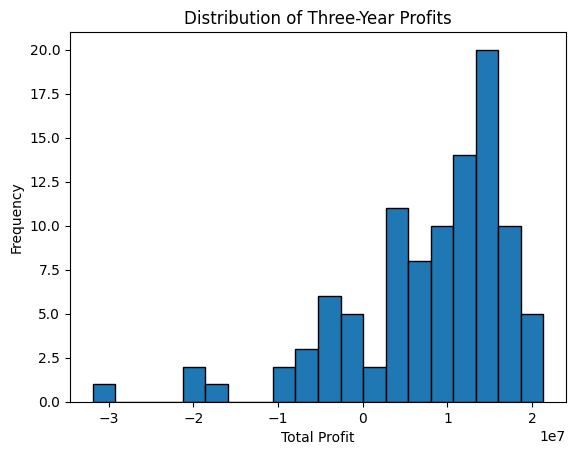

In [ ]:
import matplotlib.pyplot as plt

def simulate_and_plot(num_simulations=100):
    np.random.seed(42)

    year1_costs = []
    year2_costs = []
    year3_costs = []
    total_costs = []

    year1_revenues = []
    year2_revenues = []
    year3_revenues = []
    total_revenues = []

    year1_results = []
    year2_results = []
    year3_results = []
    total_results = []

    for _ in range(num_simulations):
        year1_total_cost, year2_total_cost, year3_total_cost, three_year_cost, \
        year1_total_revenue, year2_total_revenue, year3_total_revenue, \
        three_year_revenue, year1_total_profit, year2_total_profit, \
        year3_total_profit, three_year_profit = three_year_sim()

        year1_costs.append(year1_total_cost)
        year2_costs.append(year2_total_cost)
        year3_costs.append(year3_total_cost)
        total_costs.append(three_year_cost)

        year1_revenues.append(year1_total_revenue)
        year2_revenues.append(year2_total_revenue)
        year3_revenues.append(year3_total_revenue)
        total_revenues.append(three_year_revenue)

        year1_results.append(year1_total_profit)
        year2_results.append(year2_total_profit)
        year3_results.append(year3_total_profit)
        total_results.append(three_year_profit)

    #year 1
    mean_cost = np.mean(year1_costs)
    std_cost = np.std(year1_costs)

    mean_revenue = np.mean(year1_revenues)
    std_revenue = np.std(year1_revenues)

    mean_profit = np.mean(year1_results)
    std_profit = np.std(year1_results)

    print(f'Year 1 Mean Cost: {mean_cost:.2f}')
    print(f'Cost Standard Deviation: {std_cost:.2f}')

    print(f'Year 1 Mean Profit: {mean_revenue:.2f}')
    print(f'Revenue Standard Deviation: {std_revenue:.2f}')

    print(f'Year 1 Mean Profit: {mean_profit:.2f}')
    print(f'Profit Standard Deviation: {std_profit:.2f}')

    plt.hist(year1_results, bins=20, edgecolor='black')
    plt.title('Distribution of Year 1 Profits')
    plt.xlabel('Total Profit')
    plt.ylabel('Frequency')
    plt.show()

    #year 2
    mean_cost = np.mean(year2_costs)
    std_cost = np.std(year2_costs)

    mean_revenue = np.mean(year2_revenues)
    std_revenue = np.std(year2_revenues)

    mean_profit = np.mean(year2_results)
    std_profit = np.std(year2_results)

    print(f'Year 2 Mean Cost: {mean_cost:.2f}')
    print(f'Cost Standard Deviation: {std_cost:.2f}')

    print(f'Year 2 Mean Profit: {mean_revenue:.2f}')
    print(f'Revenue Standard Deviation: {std_revenue:.2f}')

    print(f'Year 2 Mean Profit: {mean_profit:.2f}')
    print(f'Profit Standard Deviation: {std_profit:.2f}')

    plt.hist(year2_results, bins=20, edgecolor='black')
    plt.title('Distribution of Year 2 Profits')
    plt.xlabel('Total Profit')
    plt.ylabel('Frequency')
    plt.show()

    #year 3
    mean_cost = np.mean(year3_costs)
    std_cost = np.std(year3_costs)

    mean_revenue = np.mean(year3_revenues)
    std_revenue = np.std(year3_revenues)

    mean_profit = np.mean(year3_results)
    std_profit = np.std(year3_results)

    print(f'Year 3 Mean Cost: {mean_cost:.2f}')
    print(f'Cost Standard Deviation: {std_cost:.2f}')

    print(f'Year 3 Mean Profit: {mean_revenue:.2f}')
    print(f'Revenue Standard Deviation: {std_revenue:.2f}')

    print(f'Year 3 Mean Profit: {mean_profit:.2f}')
    print(f'Profit Standard Deviation: {std_profit:.2f}')
    plt.hist(year3_results, bins=20, edgecolor='black')
    plt.title('Distribution of Year 3 Profits')
    plt.xlabel('Total Profit')
    plt.ylabel('Frequency')
    plt.show()

    #three years total
    mean_cost = np.mean(total_costs)
    std_cost = np.std(total_costs)

    mean_revenue = np.mean(total_revenues)
    std_revenue = np.std(total_revenues)

    mean_profit = np.mean(total_results)
    std_profit = np.std(total_results)

    print(f'Three Year Mean Cost: {mean_cost:.2f}')
    print(f'Cost Standard Deviation: {std_cost:.2f}')

    print(f'Three Year Mean Revenue: {mean_revenue:.2f}')
    print(f'Revenue Standard Deviation: {std_revenue:.2f}')

    print(f'Three Year Mean Profit: {mean_profit:.2f}')
    print(f'Profit Standard Deviation: {std_profit:.2f}')

    plt.hist(total_results, bins=20, edgecolor='black')
    plt.title('Distribution of Three-Year Profits')
    plt.xlabel('Total Profit')
    plt.ylabel('Frequency')
    plt.show()

simulate_and_plot(num_simulations=100)

*Distributions (500 simulations)*

Three Year Mean Cost: 21596214.08
Cost Standard Deviation: 9190429.14
Three Year Mean Revenue: 28749241.51
Revenue Standard Deviation: 1113334.01
Three Year Mean Profit: 7153027.43
Profit Standard Deviation: 9220941.93


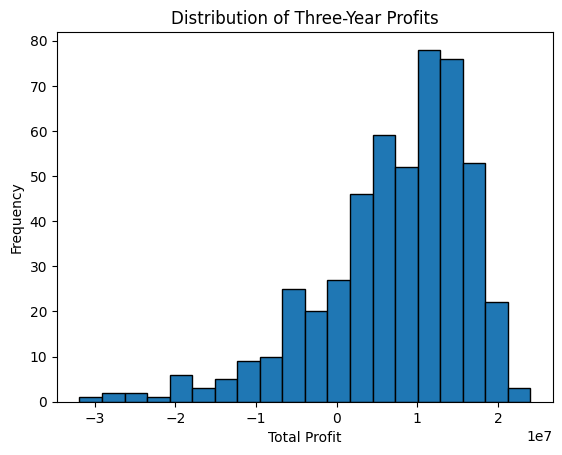

In [ ]:
import matplotlib.pyplot as plt

def simulate_and_plot(num_simulations=500):
    np.random.seed(42)

    year1_costs = []
    year2_costs = []
    year3_costs = []
    total_costs = []

    year1_revenues = []
    year2_revenues = []
    year3_revenues = []
    total_revenues = []

    year1_results = []
    year2_results = []
    year3_results = []
    total_results = []

    for _ in range(num_simulations):
        year1_total_cost, year2_total_cost, year3_total_cost, three_year_cost, \
        year1_total_revenue, year2_total_revenue, year3_total_revenue, \
        three_year_revenue, year1_total_profit, year2_total_profit, \
        year3_total_profit, three_year_profit = three_year_sim()

        total_costs.append(three_year_cost)

        total_revenues.append(three_year_revenue)

        total_results.append(three_year_profit)

    #three years total
    mean_cost = np.mean(total_costs)
    std_cost = np.std(total_costs)

    mean_revenue = np.mean(total_revenues)
    std_revenue = np.std(total_revenues)

    mean_profit = np.mean(total_results)
    std_profit = np.std(total_results)

    print(f'Three Year Mean Cost: {mean_cost:.2f}')
    print(f'Cost Standard Deviation: {std_cost:.2f}')

    print(f'Three Year Mean Revenue: {mean_revenue:.2f}')
    print(f'Revenue Standard Deviation: {std_revenue:.2f}')

    print(f'Three Year Mean Profit: {mean_profit:.2f}')
    print(f'Profit Standard Deviation: {std_profit:.2f}')

    plt.hist(total_results, bins=20, edgecolor='black')
    plt.title('Distribution of Three-Year Profits')
    plt.xlabel('Total Profit')
    plt.ylabel('Frequency')
    plt.show()

simulate_and_plot(num_simulations=500)

## Question 3

In [ ]:
def simulate_by_risk_level(risk_level):
  data = pd.read_excel('RegencyClientList.xlsx')
  df = data[data['Risk Rating'] <= risk_level]

  #year 1
  year1_total_cost, year1_total_revenue, year1_total_profit, df = simulation(df, 1)

  #year 2
  year2_total_cost, year2_total_revenue, year2_total_profit, df = simulation(df, 2)

  #year 3
  year3_total_cost, year3_total_revenue, year3_total_profit, df = simulation(df, 3)

  #sum three years
  three_year_cost = year1_total_cost + year2_total_cost + year3_total_cost
  three_year_revenue = year1_total_revenue + year2_total_revenue + year3_total_revenue
  three_year_profit = year1_total_profit + year2_total_profit + year3_total_profit

  return year1_total_profit, year2_total_profit, year3_total_profit, three_year_profit

*Risk level <= 7*

In [ ]:
def simulate_and_plot(num_simulations=500):
    np.random.seed(42)

    year1_results = []
    year2_results = []
    year3_results = []
    total_results = []

    for _ in range(num_simulations):
        year1_profit, year2_profit, year3_profit,three_year_profit = simulate_by_risk_level(7)
        year1_results.append(year1_profit)
        year2_results.append(year2_profit)
        year3_results.append(year3_profit)
        total_results.append(three_year_profit)

    #year 1
    mean_profit = np.mean(year1_results)
    print(f'Year 1 Mean Profit: {mean_profit:.2f}')

    #year 2
    mean_profit = np.mean(year2_results)
    print(f'Year 2 Mean Profit: {mean_profit:.2f}')

    #year 3
    mean_profit = np.mean(year3_results)
    print(f'Year 3 Mean Profit: {mean_profit:.2f}')

    #three years total
    mean_profit = np.mean(total_results)
    std_profit = np.std(total_results)
    print(f'Three Year Mean Profit: {mean_profit:.2f}')
    print(f'Profit Standard Deviation: {std_profit:.2f}')

simulate_and_plot(num_simulations=500)

Year 1 Mean Profit: 1474199.99
Year 2 Mean Profit: 2957869.80
Year 3 Mean Profit: 2720957.64
Three Year Mean Profit: 7153027.43
Profit Standard Deviation: 9220941.93


*Risk level <= 6*

In [ ]:
def simulate_and_plot(num_simulations=500):
    np.random.seed(42)

    year1_results = []
    year2_results = []
    year3_results = []
    total_results = []

    for _ in range(num_simulations):
        year1_profit, year2_profit, year3_profit,three_year_profit = simulate_by_risk_level(6)
        year1_results.append(year1_profit)
        year2_results.append(year2_profit)
        year3_results.append(year3_profit)
        total_results.append(three_year_profit)

    #year 1
    mean_profit = np.mean(year1_results)
    print(f'Year 1 Mean Profit: {mean_profit:.2f}')

    #year 2
    mean_profit = np.mean(year2_results)
    print(f'Year 2 Mean Profit: {mean_profit:.2f}')

    #year 3
    mean_profit = np.mean(year3_results)
    print(f'Year 3 Mean Profit: {mean_profit:.2f}')

    #three years total
    mean_profit = np.mean(total_results)
    std_profit = np.std(total_results)
    print(f'Three Year Mean Profit: {mean_profit:.2f}')
    print(f'Profit Standard Deviation: {std_profit:.2f}')

simulate_and_plot(num_simulations=500)

Year 1 Mean Profit: 2611471.11
Year 2 Mean Profit: 3932200.66
Year 3 Mean Profit: 3641573.36
Three Year Mean Profit: 10185245.14
Profit Standard Deviation: 7949808.04


*Risk level <= 5*

In [ ]:
def simulate_and_plot(num_simulations=500):
    np.random.seed(42)

    year1_results = []
    year2_results = []
    year3_results = []
    total_results = []

    for _ in range(num_simulations):
        year1_profit, year2_profit, year3_profit,three_year_profit = simulate_by_risk_level(5)
        year1_results.append(year1_profit)
        year2_results.append(year2_profit)
        year3_results.append(year3_profit)
        total_results.append(three_year_profit)

    #year 1
    mean_profit = np.mean(year1_results)
    print(f'Year 1 Mean Profit: {mean_profit:.2f}')

    #year 2
    mean_profit = np.mean(year2_results)
    print(f'Year 2 Mean Profit: {mean_profit:.2f}')

    #year 3
    mean_profit = np.mean(year3_results)
    print(f'Year 3 Mean Profit: {mean_profit:.2f}')

    #three years total
    mean_profit = np.mean(total_results)
    std_profit = np.std(total_results)
    print(f'Three Year Mean Profit: {mean_profit:.2f}')
    print(f'Profit Standard Deviation: {std_profit:.2f}')

simulate_and_plot(num_simulations=500)

Year 1 Mean Profit: 2987436.62
Year 2 Mean Profit: 3806649.04
Year 3 Mean Profit: 3849759.02
Three Year Mean Profit: 10643844.69
Profit Standard Deviation: 7900861.84


*Risk level <= 4*

In [ ]:
def simulate_and_plot(num_simulations=500):
    np.random.seed(42)

    year1_results = []
    year2_results = []
    year3_results = []
    total_results = []

    for _ in range(num_simulations):
        year1_profit, year2_profit, year3_profit,three_year_profit = simulate_by_risk_level(4)
        year1_results.append(year1_profit)
        year2_results.append(year2_profit)
        year3_results.append(year3_profit)
        total_results.append(three_year_profit)

    #year 1
    mean_profit = np.mean(year1_results)
    print(f'Year 1 Mean Profit: {mean_profit:.2f}')

    #year 2
    mean_profit = np.mean(year2_results)
    print(f'Year 2 Mean Profit: {mean_profit:.2f}')

    #year 3
    mean_profit = np.mean(year3_results)
    print(f'Year 3 Mean Profit: {mean_profit:.2f}')

    #three years total
    mean_profit = np.mean(total_results)
    std_profit = np.std(total_results)
    print(f'Three Year Mean Profit: {mean_profit:.2f}')
    print(f'Profit Standard Deviation: {std_profit:.2f}')

simulate_and_plot(num_simulations=500)

Year 1 Mean Profit: 2317199.17
Year 2 Mean Profit: 3363649.14
Year 3 Mean Profit: 3307699.33
Three Year Mean Profit: 8988547.64
Profit Standard Deviation: 6216552.82


*Risk level <= 3*

In [ ]:
def simulate_and_plot(num_simulations=500):
    np.random.seed(42)

    year1_results = []
    year2_results = []
    year3_results = []
    total_results = []

    for _ in range(num_simulations):
        year1_profit, year2_profit, year3_profit,three_year_profit = simulate_by_risk_level(3)
        year1_results.append(year1_profit)
        year2_results.append(year2_profit)
        year3_results.append(year3_profit)
        total_results.append(three_year_profit)

    #year 1
    mean_profit = np.mean(year1_results)
    print(f'Year 1 Mean Profit: {mean_profit:.2f}')

    #year 2
    mean_profit = np.mean(year2_results)
    print(f'Year 2 Mean Profit: {mean_profit:.2f}')

    #year 3
    mean_profit = np.mean(year3_results)
    print(f'Year 3 Mean Profit: {mean_profit:.2f}')

    #three years total
    mean_profit = np.mean(total_results)
    std_profit = np.std(total_results)
    print(f'Three Year Mean Profit: {mean_profit:.2f}')
    print(f'Profit Standard Deviation: {std_profit:.2f}')

simulate_and_plot(num_simulations=500)

Year 1 Mean Profit: 1400165.35
Year 2 Mean Profit: 1975934.77
Year 3 Mean Profit: 1814313.00
Three Year Mean Profit: 5190413.12
Profit Standard Deviation: 4368035.65


*Risk level <= 2*

In [ ]:
def simulate_and_plot(num_simulations=100):
    np.random.seed(42)

    year1_results = []
    year2_results = []
    year3_results = []
    total_results = []

    for _ in range(num_simulations):
        year1_profit, year2_profit, year3_profit,three_year_profit = simulate_by_risk_level(2)
        year1_results.append(year1_profit)
        year2_results.append(year2_profit)
        year3_results.append(year3_profit)
        total_results.append(three_year_profit)

    #year 1
    mean_profit = np.mean(year1_results)
    print(f'Year 1 Mean Profit: {mean_profit:.2f}')

    #year 2
    mean_profit = np.mean(year2_results)
    print(f'Year 2 Mean Profit: {mean_profit:.2f}')

    #year 3
    mean_profit = np.mean(year3_results)
    print(f'Year 3 Mean Profit: {mean_profit:.2f}')

    #three years total
    mean_profit = np.mean(total_results)
    std_profit = np.std(total_results)
    print(f'Three Year Mean Profit: {mean_profit:.2f}')
    print(f'Profit Standard Deviation: {std_profit:.2f}')

simulate_and_plot(num_simulations=100)

Year 1 Mean Profit: 215070.74
Year 2 Mean Profit: 709301.11
Year 3 Mean Profit: 501354.14
Three Year Mean Profit: 1425726.00
Profit Standard Deviation: 1272846.01


*Risk level <= 1*

In [ ]:
def simulate_and_plot(num_simulations=50):
    np.random.seed(42)

    year1_results = []
    year2_results = []
    year3_results = []
    total_results = []

    for _ in range(num_simulations):
        year1_profit, year2_profit, year3_profit,three_year_profit = simulate_by_risk_level(1)
        year1_results.append(year1_profit)
        year2_results.append(year2_profit)
        year3_results.append(year3_profit)
        total_results.append(three_year_profit)

    #year 1
    mean_profit = np.mean(year1_results)
    print(f'Year 1 Mean Profit: {mean_profit:.2f}')

    #year 2
    mean_profit = np.mean(year2_results)
    print(f'Year 2 Mean Profit: {mean_profit:.2f}')

    #year 3
    mean_profit = np.mean(year3_results)
    print(f'Year 3 Mean Profit: {mean_profit:.2f}')

    #three years total
    mean_profit = np.mean(total_results)
    std_profit = np.std(total_results)
    print(f'Three Year Mean Profit: {mean_profit:.2f}')
    print(f'Profit Standard Deviation: {std_profit:.2f}')

simulate_and_plot(num_simulations=50)

Year 1 Mean Profit: -99578.62
Year 2 Mean Profit: 378828.09
Year 3 Mean Profit: 396572.73
Three Year Mean Profit: 675822.19
Profit Standard Deviation: 469404.64


## Question 4

In [ ]:
def simulate_by_risk_level_complexity_size(risk_level, complexity_threshold, size_threshold, data):
  df = data[(data['Risk Rating'] <= risk_level) & (data['Complexity Level'] <= complexity_threshold) & (data['Annual Spend Volume'] >= size_threshold)]

  clients = len(df)
  #year 1
  year1_total_cost, year1_total_revenue, year1_total_profit, df = simulation(df, 1)

  #year 2
  year2_total_cost, year2_total_revenue, year2_total_profit, df = simulation(df, 2)

  #year 3
  year3_total_cost, year3_total_revenue, year3_total_profit, df = simulation(df, 3)

  #sum three years
  three_year_cost = year1_total_cost + year2_total_cost + year3_total_cost
  three_year_revenue = year1_total_revenue + year2_total_revenue + year3_total_revenue
  three_year_profit = year1_total_profit + year2_total_profit + year3_total_profit

  return year1_total_profit, year2_total_profit, year3_total_profit, three_year_profit, clients

In [ ]:
def simulate_and_plot_q4(num_simulations=500, seed=42, risk_threshold = 7, complexity_threshold = 3, size_threshold = 0, data_source = 0):
    # Set the random seed for reproducibility
    np.random.seed(seed)
    year1_results = []
    year2_results = []
    year3_results = []
    total_results = []

    for _ in range(num_simulations):
        year1_profit, year2_profit, year3_profit,three_year_profit, num_clients = simulate_by_risk_level_complexity_size(risk_threshold,complexity_threshold,size_threshold,data_source)
        year1_results.append(year1_profit)
        year2_results.append(year2_profit)
        year3_results.append(year3_profit)
        total_results.append(three_year_profit)

    #year 1
    mean_profit1 = np.mean(year1_results)
    #print(f'Year 1 Mean Profit: {mean_profit:.2f}')

    #year 2
    mean_profit2 = np.mean(year2_results)
    #print(f'Year 2 Mean Profit: {mean_profit:.2f}')

    #year 3
    mean_profit3 = np.mean(year3_results)
    #print(f'Year 3 Mean Profit: {mean_profit:.2f}')

    #three years total
    mean_profit = np.mean(total_results)
    #print(f'Three Year Mean Profit: {mean_profit:.2f}')

    return mean_profit1, mean_profit2, mean_profit3, mean_profit, num_clients

In [ ]:
import warnings
# Suppress FutureWarning related to DataFrame append method
warnings.simplefilter(action='ignore', category=FutureWarning)

risk_thresholds = [4,5,6,7]
complexity_thresholds = [1,2,3]
size_thresholds = [100000, 150000, 200000, 250000]
df_source = pd.read_excel('RegencyClientList.xlsx')

best_profit = 0
best_profit1 = 0
best_profit2 = 0
best_profit3 = 0
best_risk = 0
best_complexity = 0
best_size = 0
best_clients = 0

columns = ['risk_threshold', 'complexity_threshold', 'annual_spend_threshold', 'profit1', 'profit2', 'profit3', 'profit', 'clients']
result_df = pd.DataFrame(columns=columns)

for risk_level in risk_thresholds:
    for complexity_level in complexity_thresholds:
        for size_level in size_thresholds:
            profit1, profit2, profit3, profit, clients = (simulate_and_plot_q4(num_simulations=100, seed=42, risk_threshold=risk_level, complexity_threshold=complexity_level, size_threshold=size_level, data_source=df_source))
            print(f"Risk: {risk_level}, Complexity: {complexity_level}, Size: {size_level}, Mean Profit Year 1: {profit1:.2f}, Mean Profit Year 2: {profit2:.2f}, Mean Profit Year 3: {profit3:.2f}, Mean Profit Overall: {profit:.2f}, Clients: {clients}")

            result_df = result_df.append({'risk_threshold': risk_level, 'complexity_threshold': complexity_level, 'annual_spend_threshold':size_level, 'profit1': profit1, 'profit2': profit2, 'profit3': profit3, 'profit': profit,'clients': clients}, ignore_index=True)

            if profit > best_profit:
                best_risk = risk_level
                best_complexity = complexity_level
                best_size = size_level
                best_profit = profit
                best_profit1 = profit1
                best_profit2 = profit2
                best_profit3 = profit3
                best_clients = clients

print(f"Best Solution:\nRisk: {best_risk}, Complexity: {best_complexity}, Size: {best_size},\nMean Profit Year 1: {best_profit1:.2f}, Mean Profit Year 2: {best_profit2:.2f}, Mean Profit Year 3: {best_profit3:.2f},\nMean Profit Overall: {best_profit:.2f}, Clients: {best_clients}")